In [1]:
!pip install statsbombpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 6.1 MB/s eta 0:00:00


In [2]:
from statsbombpy import sb
import pandas as pd

matches = sb.matches(competition_id=11, season_id=27)
matches.head()

/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3825848,2015-09-23,20:00:00.000,Spain - La Liga,2015/2016,Levante UD,Eibar,2,2,available,...,None,5,Regular Season,Estadio Ciudad de Valencia,NaN,Luis Lucas Alcaraz González,José Luis Mendilibar Etxebarria,1.1.0,2,2
1,3825895,2015-09-23,22:00:00.000,Spain - La Liga,2015/2016,Las Palmas,Sevilla,2,0,available,...,None,5,Regular Season,Estadio de Gran Canaria,Carlos del Cerro Grande,Francisco Herrera Lorenzo,Unai Emery Etxegoien,1.1.0,2,2
2,3825894,2016-05-01,18:15:00.000,Spain - La Liga,2015/2016,RC Deportivo La Coruña,Getafe,0,2,available,...,None,36,Regular Season,Estadio Abanca-Riazor,Carlos Clos Gómez,Víctor Sánchez del Amo,Juan Eduardo Esnáider Belén,1.1.0,2,2
3,3825855,2016-05-02,20:30:00.000,Spain - La Liga,2015/2016,Málaga,Levante UD,3,1,available,...,None,36,Regular Season,Estadio La Rosaleda,Iñaki Bikandi Garrido,Javier Gracia Carlos,Joan Francesc Ferrer Sicilia,1.1.0,2,2
4,3825908,2016-05-15,19:00:00.000,Spain - La Liga,2015/2016,Espanyol,Eibar,4,2,available,...,None,38,Regular Season,RCDE Stadium,Mario Melero López,Constantin Gâlcă,José Luis Mendilibar Etxebarria,1.1.0,2,2


##Simulation of model
As the results show, a CAVI gets good correlation with all latent variables

In [3]:
import numpy as np

def safe_exp(x):
    return np.exp(np.clip(x, -15, 15))

def corr(a, b):
    a = (a - a.mean()) / (a.std() + 1e-12)
    b = (b - b.mean()) / (b.std() + 1e-12)
    return float(np.mean(a * b))


# ============================================================
# 1) SIMULATE  (hierarchical θ | τ)
# ============================================================
def simulate(
    P=200, T=20, O=20, M=12000, seed=0,
    sigma_tau=0.8,
    sigma_theta=0.6,
    sigma_gamma=0.6,
):
    rng = np.random.default_rng(seed)

    tau = rng.normal(0, sigma_tau, size=T)
    gamma = rng.normal(0, sigma_gamma, size=O)

    player_team = rng.integers(0, T, size=P)
    theta = rng.normal(tau[player_team], sigma_theta)

    p = rng.integers(0, P, size=M)
    team = player_team[p]
    opp = rng.integers(0, O, size=M)

    e = np.clip(rng.normal(90, 10, size=M), 20, None)
    loge = np.log(e)

    eta = theta[p] - gamma[opp] + loge
    lam = safe_exp(eta)
    y = rng.poisson(lam)

    return dict(
        P=P, T=T, O=O,
        p=p, team=team, opp=opp,
        y=y, loge=loge,
        theta_true=theta,
        tau_true=tau,
        gamma_true=gamma,
        player_team=player_team
    )


# ============================================================
# 2) FIT  (coordinate ascent / Laplace MAP)
# ============================================================
def fit(data, max_iter=60, newton_steps=5):
    P, T, O = data["P"], data["T"], data["O"]
    p, team, opp = data["p"], data["team"], data["opp"]
    y, loge = data["y"], data["loge"]

    rng = np.random.default_rng(1)

    theta = rng.normal(0, 0.1, size=P)
    tau   = rng.normal(0, 0.1, size=T)
    gamma = rng.normal(0, 0.1, size=O)

    rows_by_player = [np.where(p == i)[0] for i in range(P)]
    rows_by_team   = [np.where(team == t)[0] for t in range(T)]
    rows_by_opp    = [np.where(opp == o)[0] for o in range(O)]

    sigma_theta = 1.0
    sigma_tau   = 1.0
    sigma_gamma = 1.0

    for it in range(max_iter):

        # ----- update theta_p -----
        for i in range(P):
            rows = rows_by_player[i]
            if rows.size == 0:
                continue

            ti = theta[i]
            ti0 = tau[team[rows][0]]  # team mean
            for _ in range(newton_steps):
                eta = ti - gamma[opp[rows]] + loge[rows]
                lam = safe_exp(eta)

                g = np.sum(y[rows] - lam) - (ti - ti0) / sigma_theta**2
                h = -np.sum(lam) - 1.0 / sigma_theta**2

                ti -= np.clip(g / (h - 1e-12), -0.5, 0.5)
            theta[i] = ti

        # ----- update tau_t -----
        for t in range(T):
            rows = rows_by_team[t]
            if rows.size == 0:
                continue

            tt = tau[t]
            idx_players = np.unique(p[rows])
            for _ in range(newton_steps):
                g = -tt / sigma_tau**2
                h = -1.0 / sigma_tau**2
                for i in idx_players:
                    g += (theta[i] - tt) / sigma_theta**2
                    h += -1.0 / sigma_theta**2

                tt -= np.clip(g / (h - 1e-12), -0.5, 0.5)
            tau[t] = tt

        # ----- update gamma_o -----
        for o in range(O):
            rows = rows_by_opp[o]
            if rows.size == 0:
                continue

            go = gamma[o]
            for _ in range(newton_steps):
                eta = theta[p[rows]] - go + loge[rows]
                lam = safe_exp(eta)

                g = np.sum(-y[rows] + lam) - go / sigma_gamma**2
                h = -np.sum(lam) - 1.0 / sigma_gamma**2

                go -= np.clip(g / (h - 1e-12), -0.5, 0.5)
            gamma[o] = go

        # center tau for identifiability
        tau -= tau.mean()

    return dict(theta_hat=theta, tau_hat=tau, gamma_hat=gamma, iters=it + 1)


# ============================================================
# 3) RUN
# ============================================================
data = simulate()
fit_res = fit(data)

print({
    "corr(theta)": corr(data["theta_true"], fit_res["theta_hat"]),
    "corr(tau)": corr(data["tau_true"], fit_res["tau_hat"]),
    "corr(gamma)": corr(data["gamma_true"], fit_res["gamma_hat"]),
})


{'corr(theta)': 0.9997541472795072, 'corr(tau)': 0.9655826478700744, 'corr(gamma)': 0.9999672520019504}


##Getting Data

In [4]:
import pandas as pd
import numpy as np
from statsbombpy import sb

# -------------------------------
# Load multiple seasons (LaLiga)
# -------------------------------
season_ids = [26, 27, 2]  # 2014–15, 2015–16, 2016–17
matches_list = []

for sid in season_ids:
    matches_list.append(
        sb.matches(competition_id=11, season_id=sid)
    )

matches = pd.concat(matches_list, ignore_index=True)

# -------------------------------
# Helpers
# -------------------------------
def normalize_events(events):
    if "type" in events.columns:
        if isinstance(events["type"].iloc[0], dict):
            events["etype"] = events["type"].apply(lambda x: x["name"])
        else:
            events["etype"] = events["type"]
    else:
        raise ValueError("No event type column found")

    if "shot_outcome" in events.columns:
        if isinstance(events["shot_outcome"].dropna().iloc[0], dict):
            events["shot_outcome_clean"] = events["shot_outcome"].apply(
                lambda x: x["name"] if isinstance(x, dict) else None
            )
        else:
            events["shot_outcome_clean"] = events["shot_outcome"]
    else:
        events["shot_outcome_clean"] = None

    return events


def get_goals_assists_per_match(match_id, matches):
    events = sb.events(match_id=match_id)
    events = normalize_events(events)

    lineups = sb.lineups(match_id=match_id)
    match_row = matches.loc[matches["match_id"] == match_id].iloc[0]

    match_minutes = events["minute"].max()

    # -------------------------------
    # Minutes played
    # -------------------------------
    minutes = {}
    for team, df in lineups.items():
        for _, r in df.iterrows():
            minutes[r["player_id"]] = match_minutes

    subs = events[events["etype"] == "Substitution"]
    for _, r in subs.iterrows():
        out_id = r["player_id"]
        in_id = r["substitution_replacement"]
        t = r["minute"]
        minutes[out_id] = t
        minutes[in_id] = match_minutes - t

    # -------------------------------
    # Base table
    # -------------------------------
    base = []
    for team, df in lineups.items():
        opp = (
            match_row["away_team"]
            if team == match_row["home_team"]
            else match_row["home_team"]
        )
        tmp = df[["player_id", "player_name"]].copy()
        tmp["team"] = team
        tmp["opponent"] = opp
        tmp["match_id"] = match_id
        tmp["date"] = match_row["match_date"]
        tmp["minutes"] = tmp["player_id"].map(minutes).fillna(0).astype(int)
        base.append(tmp)

    base = pd.concat(base, ignore_index=True)

    # -------------------------------
    # Goals
    # -------------------------------
    goals = events[
        (events["etype"] == "Shot") &
        (events["shot_outcome_clean"] == "Goal")
    ]

    goals_ct = (
        goals.groupby("player_id")
        .size()
        .rename("goals")
        .reset_index()
    )

    # -------------------------------
    # Assists
    # -------------------------------
    passes = events[
        (events["etype"] == "Pass") &
        (events["pass_assisted_shot_id"].notna())
    ][["player_id", "pass_assisted_shot_id"]]

    shots = events[
        events["etype"] == "Shot"
    ][["id", "shot_outcome_clean"]].rename(columns={"id": "shot_id"})

    assists = passes.merge(
        shots,
        left_on="pass_assisted_shot_id",
        right_on="shot_id",
        how="left"
    )

    assists = assists[assists["shot_outcome_clean"] == "Goal"]

    assists_ct = (
        assists.groupby("player_id")
        .size()
        .rename("assists")
        .reset_index()
    )

    # -------------------------------
    # Merge + exposure
    # -------------------------------
    out = (
        base
        .merge(goals_ct, on="player_id", how="left")
        .merge(assists_ct, on="player_id", how="left")
    )

    out["goals"] = out["goals"].fillna(0).astype(int)
    out["assists"] = out["assists"].fillna(0).astype(int)
    out["goal_contributions"] = out["goals"] + out["assists"]
    out["exposure"] = (out["minutes"] / 90.0).clip(lower=1e-3, upper=1.5)

    return out


# -------------------------------
# Build multi-season table
# -------------------------------
rows = []
for mid in matches["match_id"]:
    rows.append(get_goals_assists_per_match(mid, matches))

full_table = pd.concat(rows, ignore_index=True)

# -------------------------------
# Sanity checks
# -------------------------------
print("Rows:", len(full_table))
print("Total goals:", full_table["goals"].sum())
print("Total assists:", full_table["assists"].sum())
print("Total contributions:", full_table["goal_contributions"].sum())
print("Mean exposure:", full_table["exposure"].mean())
print("Rows with assists > 0:", (full_table["assists"] > 0).sum())

full_table.head()


/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: 

Rows: 16169
Total goals: 1274
Total assists: 888
Total contributions: 2162
Mean exposure: 0.9872025343421224
Rows with assists > 0: 813


,player_id,player_name,team,opponent,match_id,date,minutes,goals,assists,goal_contributions,exposure
0,3058,Javier Hernández Balcázar,Real Madrid,Barcelona,267183,2015-03-22,92,0,0,0,1.022222
1,3990,Jesé Rodríguez Ruiz,Real Madrid,Barcelona,267183,2015-03-22,92,0,0,0,1.022222
2,4926,Francisco Román Alarcón Suárez,Real Madrid,Barcelona,267183,2015-03-22,79,0,0,0,0.877778
3,5201,Sergio Ramos García,Real Madrid,Barcelona,267183,2015-03-22,92,0,0,0,1.022222
4,5207,Cristiano Ronaldo dos Santos Aveiro,Real Madrid,Barcelona,267183,2015-03-22,92,1,0,1,1.022222


##Data Pre-Processing

In [5]:
import pandas as pd
import numpy as np


# Drop rows with missing critical fields
full_table = full_table.dropna(
    subset=["player_name", "team", "opponent", "match_id", "minutes", "goals"]
).reset_index(drop=True)

# Ensure integer goals and minutes
full_table["goals"] = full_table["goals"].astype(int)
full_table["minutes"] = full_table["minutes"].astype(int)

# Remove zero-minute appearances (cannot score)
full_table = full_table[full_table["minutes"] > 0].reset_index(drop=True)



# Exposure in units of 90 minutes
full_table["exposure"] = full_table["minutes"] / 90.0

# Safety: cap absurd values (extra time)
full_table["exposure"] = full_table["exposure"].clip(lower=1e-3, upper=1.5)



goals_by_player = (
    full_table
    .groupby("player_name")["goals"]
    .sum()
)

scorers = set(goals_by_player[goals_by_player > 0].index)

full_table["is_scorer"] = full_table["player_name"].isin(scorers).astype(int)



full_table = full_table[
    ~(
        (full_table["is_scorer"] == 0) &
        (full_table["goals"] == 0)
    )
].reset_index(drop=True)



full_table["player_id"] = full_table["player_name"].astype("category").cat.codes
full_table["team_id"]   = full_table["team"].astype("category").cat.codes
full_table["opp_id"]    = full_table["opponent"].astype("category").cat.codes
full_table["match_index"] = full_table["match_id"].astype("category").cat.codes


id_to_name = (
    full_table[["player_id", "player_name"]]
    .drop_duplicates()
    .set_index("player_id")["player_name"]
    .to_dict()
)

name_to_id = {v: k for k, v in id_to_name.items()}



player    = full_table["player_id"].values
team      = full_table["team_id"].values
opp       = full_table["opp_id"].values
match     = full_table["match_index"].values

y         = full_table["goals"].values
exposure  = full_table["exposure"].values



print("Rows:", len(full_table))
print("Unique players:", full_table["player_id"].nunique())
print("Mean exposure:", exposure.mean())
print("Fraction scorer rows:", full_table["is_scorer"].mean())

# Messi check
if "Lionel Andrés Messi Cuccittini" in name_to_id:
    mid = name_to_id["Lionel Andrés Messi Cuccittini"]
    print(
        "Messi rows:",
        (full_table["player_id"] == mid).sum(),
        "Total goals:",
        full_table.loc[full_table["player_id"] == mid, "goals"].sum()
    )


Rows: 8808
Unique players: 273
Mean exposure: 0.9747111212029468
Fraction scorer rows: 1.0
Messi rows: 105 Total goals: 106


##Run CAVI on real data

In [6]:
import numpy as np
import pandas as pd

df = full_table.copy()

player_ids = df["player_id"].unique()
team_ids   = df["team"].unique()
opp_ids    = df["opponent"].unique()

p_map = {p:i for i,p in enumerate(player_ids)}
t_map = {t:i for i,t in enumerate(team_ids)}
o_map = {o:i for i,o in enumerate(opp_ids)}

df["p"] = df["player_id"].map(p_map)
df["t"] = df["team"].map(t_map)
df["o"] = df["opponent"].map(o_map)

P, T, O = len(player_ids), len(team_ids), len(opp_ids)

p = df["p"].values
t = df["t"].values
o = df["o"].values
y = df["goal_contributions"].values.astype(float)
loge = np.log(df["exposure"].values)

sigma_theta = 0.6
sigma_tau   = 0.8
sigma_gamma = 0.6

def safe_exp(x):
    return np.exp(np.clip(x, -15, 15))

def compute_elbo(theta, tau, gamma):
    eta = theta[p] - gamma[o] + loge
    lam = safe_exp(eta)

    ll = np.sum(y * eta - lam)
    player_team = (
    df.groupby("p")["t"]
    .first()
    .values
   )
    prior_theta = -0.5 * np.sum((theta - tau[player_team])**2) / sigma_theta**2
    prior_tau   = -0.5 * np.sum(tau**2) / sigma_tau**2
    prior_gamma = -0.5 * np.sum(gamma**2) / sigma_gamma**2

    return ll + prior_theta + prior_tau + prior_gamma


rng = np.random.default_rng(0)
theta = rng.normal(0, 0.1, P)
tau   = rng.normal(0, 0.1, T)
gamma = rng.normal(0, 0.1, O)

rows_by_player = [np.where(p == i)[0] for i in range(P)]
rows_by_team   = [np.where(t == i)[0] for i in range(T)]
rows_by_opp    = [np.where(o == i)[0] for i in range(O)]

elbos = []

for it in range(60):

    # ---- theta update ----
    for i in range(P):
        rows = rows_by_player[i]
        if len(rows) == 0:
            continue

        ti = theta[i]
        ti0 = tau[t[rows][0]]

        for _ in range(5):
            eta = ti - gamma[o[rows]] + loge[rows]
            lam = safe_exp(eta)

            g = np.sum(y[rows] - lam) - (ti - ti0) / sigma_theta**2
            h = -np.sum(lam) - 1.0 / sigma_theta**2

            ti -= np.clip(g / (h - 1e-12), -0.3, 0.3)

        theta[i] = ti

    # ---- tau update ----
    for k in range(T):
        players = np.unique(p[rows_by_team[k]])
        if len(players) == 0:
            continue

        tt = tau[k]
        for _ in range(5):
            g = -tt / sigma_tau**2
            h = -1.0 / sigma_tau**2
            for i in players:
                g += (theta[i] - tt) / sigma_theta**2
                h += -1.0 / sigma_theta**2

            tt -= np.clip(g / (h - 1e-12), -0.3, 0.3)

        tau[k] = tt

    # ---- gamma update ----
    for j in range(O):
        rows = rows_by_opp[j]
        if len(rows) == 0:
            continue

        gj = gamma[j]
        for _ in range(5):
            eta = theta[p[rows]] - gj + loge[rows]
            lam = safe_exp(eta)

            g = np.sum(-y[rows] + lam) - gj / sigma_gamma**2
            h = -np.sum(lam) - 1.0 / sigma_gamma**2

            gj -= np.clip(g / (h - 1e-12), -0.3, 0.3)

        gamma[j] = gj

    # identifiability
    tau -= tau.mean()

    # ---- ELBO ----

    elbo = compute_elbo(theta, tau, gamma)
    elbos.append(elbo)

    if it % 5 == 0:
        print(f"iter {it:02d} | ELBO = {elbo:,.2f}")
df_players = pd.DataFrame({
    "player_id": player_ids,
    "theta": theta,
    "team": [df[df.player_id==pid].team.iloc[0] for pid in player_ids],
})

df_players["tau_team"] = df_players["team"].map(
    {team: tau[idx] for team, idx in t_map.items()}
)

df_players["residual_skill"] = df_players["theta"] - df_players["tau_team"]

df_players.sort_values("residual_skill", ascending=False).head(15)


iter 00 | ELBO = -4,784.03
iter 05 | ELBO = -4,343.06
iter 10 | ELBO = -4,315.98
iter 15 | ELBO = -4,314.43
iter 20 | ELBO = -4,314.43
iter 25 | ELBO = -4,314.46
iter 30 | ELBO = -4,314.47
iter 35 | ELBO = -4,314.47
iter 40 | ELBO = -4,314.47
iter 45 | ELBO = -4,314.47
iter 50 | ELBO = -4,314.47
iter 55 | ELBO = -4,314.47


,player_id,theta,team,tau_team,residual_skill
19,157,1.733093,Barcelona,0.048843,1.684251
17,162,1.602869,Barcelona,0.048843,1.554026
12,184,1.315396,Barcelona,0.048843,1.266553
3,47,1.628929,Real Madrid,0.523124,1.105806
9,153,1.621996,Real Madrid,0.523124,1.098872
7,87,1.605504,Real Madrid,0.523124,1.082380
108,104,0.983680,Real Sociedad,-0.063338,1.047017
71,24,1.053897,Athletic Club,0.046380,1.007517
226,211,0.924602,Real Betis,-0.069545,0.994147
62,158,0.984400,RC Deportivo La Coruña,0.008989,0.975411


Text(0.5, 1.0, 'ELBO convergence')

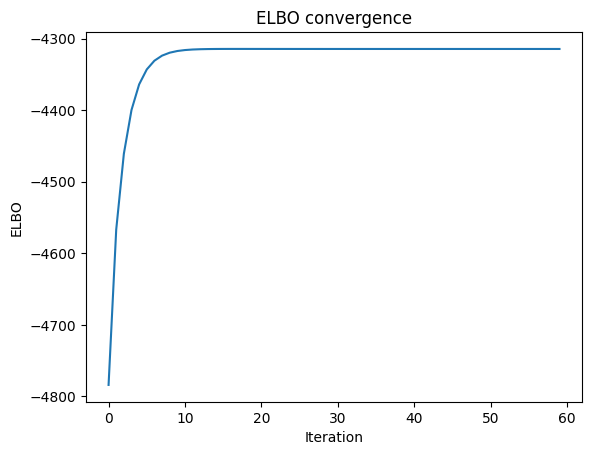

In [7]:
import matplotlib.pyplot as plt

plt.plot(elbos)
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.title("ELBO convergence")


##Results

In [8]:

theta_flat = np.zeros_like(theta)

rows_by_player = [np.where(p == i)[0] for i in range(len(theta))]

for it in range(60):
    for i in range(len(theta_flat)):
        rows = rows_by_player[i]
        if len(rows) == 0:
            continue

        ti = theta_flat[i]
        for _ in range(5):
            eta = ti - gamma[o[rows]] + loge[rows]
            lam = safe_exp(eta)

            # FLAT prior: N(0, sigma_theta^2)
            g = np.sum(y[rows] - lam) - ti / sigma_theta**2
            h = -np.sum(lam) - 1.0 / sigma_theta**2

            ti -= np.clip(g / (h - 1e-12), -0.3, 0.3)

        theta_flat[i] = ti

In [9]:
# Base quantities
y = df["goal_contributions"].values.astype(float)
loge = np.log(df["exposure"].values)
p = df["p"].values
o = df["o"].values

# ---------- FULL MODEL ----------
lam_full = safe_exp(theta[p] - gamma[o] + loge)

# ---------- NO OPPONENT ----------
lam_no_opp = safe_exp(theta[p] + loge)

# ---------- NO TEAM HIERARCHY ----------
# refit theta_flat without tau (example assumes you already did this)
lam_no_team = safe_exp(theta_flat[p] - gamma[o] + loge)

# ---------- EXPOSURE ONLY ----------
lam_exposure = safe_exp(loge)


In [10]:
match_corr = {
    "full": corr(y, lam_full),
    "no_opponent": corr(y, lam_no_opp),
    "no_team": corr(y, lam_no_team),
    "exposure_only": corr(y, lam_exposure),
}

pd.DataFrame.from_dict(match_corr, orient="index", columns=["match_corr"])


,match_corr
full,0.476008
no_opponent,0.436906
no_team,0.475796
exposure_only,-0.009505


In [11]:
df_eval = df.copy()
df_eval["lam_full"] = lam_full
df_eval["lam_no_opp"] = lam_no_opp
df_eval["lam_no_team"] = lam_no_team
df_eval["lam_exposure"] = lam_exposure

agg = df_eval.groupby("p").agg(
    y_sum=("goal_contributions", "sum"),
    lam_full=("lam_full", "sum"),
    lam_no_opp=("lam_no_opp", "sum"),
    lam_no_team=("lam_no_team", "sum"),
    lam_exposure=("lam_exposure", "sum"),
)

player_corr = {
    "full": corr(agg["y_sum"], agg["lam_full"]),
    "no_opponent": corr(agg["y_sum"], agg["lam_no_opp"]),
    "no_team": corr(agg["y_sum"], agg["lam_no_team"]),
    "exposure_only": corr(agg["y_sum"], agg["lam_exposure"]),
}

pd.DataFrame.from_dict(player_corr, orient="index", columns=["player_corr"])


,player_corr
full,0.992914
no_opponent,0.993801
no_team,0.992781
exposure_only,0.545970


In [12]:
results = pd.DataFrame({
    "match_level_corr": match_corr,
    "player_level_corr": player_corr,
})

results


,match_level_corr,player_level_corr
full,0.476008,0.992914
no_opponent,0.436906,0.993801
no_team,0.475796,0.992781
exposure_only,-0.009505,0.545970


In [13]:
from scipy.special import gammaln

def poisson_loglik(y, lam):
    return y * np.log(lam) - lam - gammaln(y + 1)


Log Liklihood

In [14]:
ll = pd.DataFrame({
    "full": poisson_loglik(y, lam_full),
    "no_opponent": poisson_loglik(y, lam_no_opp),
    "no_team": poisson_loglik(y, lam_no_team),
    "exposure_only": poisson_loglik(y, lam_exposure),
})

ll_sum = ll.sum().to_frame(name="total_loglik")
ll_sum


,total_loglik
full,-4481.839745
no_opponent,-9045.048064
no_team,-4482.294588
exposure_only,-9002.430317


In [15]:
ll_delta = ll_sum - ll_sum.loc["full"]
ll_delta.rename(columns={"total_loglik": "Δ log-likelihood"}, inplace=True)
ll_delta


,Δ log-likelihood
full,0.000000
no_opponent,-4563.208319
no_team,-0.454842
exposure_only,-4520.590571


##Players Skill

In [17]:
ga90 = (
    full_table
    .groupby("player_id", as_index=False)
    .agg(
        total_ga=("goal_contributions", "sum"),
        total_minutes=("exposure", "sum")
    )
    .assign(
        g_a_per_90=lambda x: 90 * x["total_ga"] / x["total_minutes"]
    )
    .loc[:, ["player_id", "g_a_per_90"]]
)


In [18]:
(
    df_players[["player_id","team", "residual_skill"]]
    .merge(
        full_table[["player_id", "player_name"]].drop_duplicates(),
        on="player_id",
        how="left"
    )
    .merge(
        ga90[["player_id", "g_a_per_90"]],
        on="player_id",
        how="left"
    )
    .sort_values("residual_skill", ascending=False)
    .head(20)
)


,player_id,team,residual_skill,player_name,g_a_per_90
19,157,Barcelona,1.684251,Lionel Andrés Messi Cuccittini,125.787027
17,162,Barcelona,1.554026,Luis Alberto Suárez Díaz,110.895608
12,184,Barcelona,1.266553,Neymar da Silva Santos Junior,80.469846
3,47,Real Madrid,1.105806,Cristiano Ronaldo dos Santos Aveiro,104.473106
9,153,Real Madrid,1.098872,Karim Benzema,103.503710
7,87,Real Madrid,1.082380,Gareth Frank Bale,110.749646
108,104,Real Sociedad,1.047017,Imanol Agirretxe Arruti,65.120594
71,24,Athletic Club,1.007517,Aritz Aduriz Zubeldia,62.899051
226,211,Real Betis,0.994147,Rubén Castro Martín,55.237316
62,158,RC Deportivo La Coruña,0.975411,Lucas Pérez Martínez,58.306939


In [20]:

ga_conceded = (
    full_table
    .groupby("opponent")
    .agg(
        total_ga=("goal_contributions", "sum"),
        total_minutes=("minutes", "sum")
    )
    .reset_index()
)

ga_conceded["ga_conceded_per_90"] = (
    ga_conceded["total_ga"] / ga_conceded["total_minutes"] * 90
)

ga_conceded = ga_conceded.sort_values(
    "ga_conceded_per_90", ascending=False
)

ga_conceded.head(10)


,opponent,total_ga,total_minutes,ga_conceded_per_90
5,Córdoba CF,19,2157,0.792768
8,Elche,15,1978,0.682508
16,Osasuna,16,2409,0.597758
0,Almería,11,2174,0.455382
13,Leganés,11,2482,0.398872
6,Deportivo Alavés,10,2444,0.368249
9,Espanyol,137,37077,0.332551
14,Levante UD,126,34566,0.328068
18,Rayo Vallecano,123,34283,0.322901
10,Getafe,116,34327,0.304134


In [21]:
gamma_df = pd.DataFrame({
    "opponent": list(o_map.keys()),
    "gamma": [gamma[o_map[t]] for t in o_map.keys()]
})

defense_eval = (
    ga_conceded
    .merge(gamma_df, on="opponent", how="left")
    .sort_values("gamma", ascending=False)
)

defense_eval.head(10)


,opponent,total_ga,total_minutes,ga_conceded_per_90,gamma
25,Atlético Madrid,35,36197,0.087024,2.395239
24,Málaga,51,36128,0.127048,2.063729
23,Barcelona,117,74311,0.141702,1.969409
22,Villarreal,66,36990,0.160584,1.899680
21,Real Madrid,68,35776,0.171064,1.772260
19,Real Sociedad,84,36808,0.205390,1.671643
20,Athletic Club,85,37575,0.203593,1.626507
18,Valencia,92,38726,0.213810,1.615964
17,Sevilla,94,36738,0.230279,1.557340
16,Celta Vigo,96,35437,0.243813,1.480526
